# Exp for evaluating the performance of the model

In [47]:
import datetime
import os
import time
import sys
sys.path.append('../')

import presets
import torch
import torch.utils.data
import torchvision
import torchvision.models.detection
import torchvision.models.detection.mask_rcnn
import utils
from coco_utils import get_coco
from engine import evaluate, train_one_epoch
from group_by_aspect_ratio import create_aspect_ratio_groups, GroupedBatchSampler
from torchvision.transforms import InterpolationMode
from transforms import SimpleCopyPaste

In [48]:
import argparse

parser = argparse.ArgumentParser(description='PyTorch Detection Testing')

parser.add_argument(
    "--dataset",
    default="coco",
    type=str,
    help="dataset name. Use coco for object detection and instance segmentation and coco_kp for Keypoint detection",
)
parser.add_argument('--data-path', default='/home/hslee/Desktop/Datasets/COCO', help='path to dataset')
parser.add_argument('--test-only', action='store_true', help='only test the model')
parser.add_argument("--model", default="retinanet_resnet50_fpn", type=str, help="model name")
parser.add_argument("--device", default="cuda", type=str, help="device (Use cuda or cpu Default: cuda)")
parser.add_argument(
    "-b", "--batch-size", default=2, type=int, help="images per gpu, the total batch size is $NGPU x batch_size"
)
parser.add_argument("--weights", default="/home/hslee/Desktop/Embedded_AI/INU_4-1/RISE/01_pytorch-reference-retinanet/model_25.pth", type=str, help="the weights enum name to load")
parser.add_argument('--weights-path', default='/home/hslee/Desktop/Embedded_AI/INU_4-1/RISE/01_pytorch-reference-retinanet/model_25.pth', help='path to weights file')

parser.add_argument("--backend", default="PIL", type=str.lower, help="PIL or tensor - case insensitive")
parser.add_argument("--use-v2", action="store_true", help="Use V2 transforms")

args = parser.parse_args(args=[])

In [49]:
# get device by using parser
device = torch.device(args.device)
print(device)

cuda


In [50]:

def get_dataset(is_train, args):
    image_set = "train" if is_train else "val"
    num_classes, mode = {"coco": (91, "instances"), "coco_kp": (2, "person_keypoints")}[args.dataset]
    with_masks = "mask" in args.model
    ds = get_coco(
        root=args.data_path,
        image_set=image_set,
        transforms=get_transform(is_train, args),
        mode=mode,
        use_v2=args.use_v2,
        with_masks=with_masks,
    )
    return ds, num_classes

def get_transform(is_train, args):
    if is_train:
        return presets.DetectionPresetTrain(
            data_augmentation=args.data_augmentation, backend=args.backend, use_v2=args.use_v2
        )
    elif args.weights and args.test_only:
        weights = torchvision.models.get_weight(args.weights)
        print(weights)
        trans = weights.transforms()
        return lambda img, target: (trans(img), target)
    else:
        return presets.DetectionPresetEval(backend=args.backend, use_v2=args.use_v2)


In [51]:
def get_dataset(is_train, args):
    image_set = "train" if is_train else "val"
    num_classes, mode = {"coco": (91, "instances"), "coco_kp": (2, "person_keypoints")}[args.dataset]
    with_masks = "mask" in args.model
    ds = get_coco(
        root="/home/hslee/Desktop/Datasets/COCO",
        image_set=image_set,
        transforms=get_transform(is_train, args),
        mode=mode,
        with_masks=with_masks,
    )
    return ds, num_classes

In [52]:
dataset_test, _ = get_dataset(is_train=False, args=args)
test_sampler = torch.utils.data.SequentialSampler(dataset_test)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=8, sampler=test_sampler, num_workers=8, collate_fn=utils.collate_fn
)

loading annotations into memory...
Done (t=0.40s)
creating index...
index created!


In [53]:
reference_retinanet = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=False)
checkpoint = torch.load(args.weights_path)

reference_retinanet.load_state_dict(checkpoint['model'])

<All keys matched successfully>

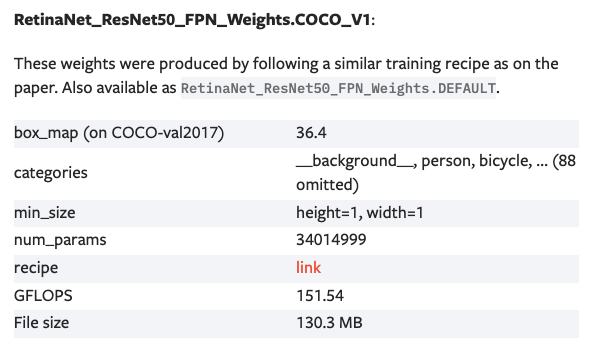

In [56]:
# the number of all parameters
print(sum(p.numel() for p in reference_retinanet.parameters()))

34014999


In [26]:
reference_retinanet.to(device)

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, e

In [27]:
# engine.py > def evaluate(model, data_loader, device):
torch.backends.cudnn.deterministic = True
evaluate(reference_retinanet, data_loader_test, device=device)

Test:  [  0/625]  eta: 0:10:03  model_time: 0.3321 (0.3321)  evaluator_time: 0.0386 (0.0386)  time: 0.9652  data: 0.5836  max mem: 5481
Test:  [100/625]  eta: 0:03:21  model_time: 0.3248 (0.3219)  evaluator_time: 0.0418 (0.0442)  time: 0.3865  data: 0.0079  max mem: 5852
Test:  [200/625]  eta: 0:02:41  model_time: 0.3259 (0.3217)  evaluator_time: 0.0406 (0.0438)  time: 0.3813  data: 0.0077  max mem: 5852
Test:  [300/625]  eta: 0:02:02  model_time: 0.3260 (0.3204)  evaluator_time: 0.0348 (0.0432)  time: 0.3667  data: 0.0075  max mem: 5852
Test:  [400/625]  eta: 0:01:24  model_time: 0.3259 (0.3204)  evaluator_time: 0.0331 (0.0434)  time: 0.3701  data: 0.0076  max mem: 5852
Test:  [500/625]  eta: 0:00:47  model_time: 0.3233 (0.3200)  evaluator_time: 0.0331 (0.0433)  time: 0.3644  data: 0.0081  max mem: 5852
Test:  [600/625]  eta: 0:00:09  model_time: 0.3235 (0.3276)  evaluator_time: 0.0381 (0.0431)  time: 0.3743  data: 0.0080  max mem: 5853
Test:  [624/625]  eta: 0:00:00  model_time: 0.32

# Inference Time

In [9]:
def get_transform(is_train, args):
    if is_train:
        return presets.DetectionPresetTrain(
            data_augmentation=args.data_augmentation, backend=args.backend, use_v2=args.use_v2
        )
    # elif args.weights and args.test_only:
    #     weights = torchvision.models.get_weight(args.weights)
    #     trans = weights.transforms()
    #     return lambda img, target: (trans(img), target)
    else:
        return presets.DetectionPresetEval(backend=args.backend, use_v2=args.use_v2)
def get_dataset(is_train, args):
    image_set = "train" if is_train else "val"
    num_classes, mode = {"coco": (91, "instances"), "coco_kp": (2, "person_keypoints")}[args.dataset]
    with_masks = "mask" in args.model
    ds = get_coco(
        root=args.data_path,
        image_set=image_set,
        transforms=get_transform(is_train, args),
        mode=mode,
        use_v2=args.use_v2,
        with_masks=with_masks,
    )
    return ds, num_classes

In [45]:
# load coco test dataset
dataset_test, _ = get_dataset(is_train=False, args=args)
test_sampler = torch.utils.data.SequentialSampler(dataset_test)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=8, sampler=test_sampler, num_workers=8, collate_fn=utils.collate_fn
)
input_tensor = next(iter(data_loader_test))[0][0].to(args.device)
print(input_tensor.shape)

reference_retinanet = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=False)
checkpoint = torch.load(args.weights_path)
reference_retinanet.load_state_dict(checkpoint['model'])
reference_retinanet.to(args.device)
reference_retinanet.eval()

starter = torch.cuda.Event(enable_timing=True)
ender = torch.cuda.Event(enable_timing=True)

with torch.no_grad(): # Gradient 연산 비활성화
    starter.record()
    output = reference_retinanet(input_tensor)
    ender.record()
    
torch.cuda.synchronize() # Gpu 연산이 완료될 때까지 대기

infer_time = starter.elapsed_time(ender)
print("Elapsed time: {} s".format(infer_time * 1e-3)) # milliseconds to second
 

loading annotations into memory...
Done (t=0.32s)
creating index...
index created!
torch.Size([3, 426, 640])


/home/hslee/anaconda3/envs/DL/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hslee/anaconda3/envs/DL/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ValueError: images is expected to be a list of 3d tensors of shape [C, H, W], got torch.Size([426, 640])